In [1]:
import json
import os
import cv2
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd
import itertools
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation, BatchNormalization

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import math
import pickle

from numpy.random import seed
from tensorflow import random

from sklearn.model_selection import KFold

In [4]:
DATA_DIR = './data8/'
ids = os.listdir(DATA_DIR)
pvm_angels = []
json_fps = [os.path.join(DATA_DIR, image_id) for image_id in ids if image_id.startswith('catalog') and image_id.endswith('catalog')]
for file in json_fps:
    with open(file, 'r') as f:
        for line in f:            
            if (line.startswith('{')):
                jsonObj = json.loads(line)   
                imgFile = jsonObj['cam/image_array']
                path = os.path.join(DATA_DIR, 'images', imgFile)
                throttle = jsonObj['user/throttle']
                if throttle != 0.0  and os.path.exists(path):
                    image = cv2.imread(path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB )
                    image = cv2.resize(image, None, fx=0.50, fy= 0.50)
                    jsonObj['image'] = image
                    pvm_angels.append(jsonObj)


In [5]:
import albumentations as A

transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.5, brightness_by_max=False, p=1),    
     A.OneOf(
        [
            #A.IAASharpen(p=1),
            A.Sharpen(p=1),
            A.Blur(blur_limit=3, p=1),
            A.MotionBlur(blur_limit=3, p=1),
        ],
        p=0.9,
    ),
])

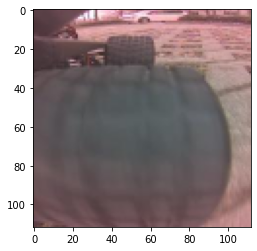

(112, 112, 3)

In [6]:
plt.imshow(pvm_angels[0]['image'])
plt.show()
pvm_angels[0]['image'].shape

# Prepare

In [7]:
#prepare and split data


def extract(pvm_angels):
    df = pd.DataFrame(pvm_angels)

    images = np.array(list(df['image']), dtype='f')    
    images = images / 255.0
    pwms = np.array(df['user/angle'])
    
    images = np.array(images) 
    pwms = np.array(pwms)
    
    return(images, pwms)

In [8]:
def apply_augmentation(images,pwms):
    #implment augmentation 
    augmentedTrainImages = []
    for i in range(len(images)):
        orig_image = images[i]
        augmentedTrainImages.append(orig_image)
        for j in range(9):
            augmentedTrainImages.append(transform(image=orig_image)['image'])
    return (np.array(augmentedTrainImages), np.array(pwms).repeat(10))

# Usage

In [11]:
def calc_ackerman(pwms):
    #calculates on left wheel
    L = 178 #wheelbase
    b = 165 #
    pwm_max = 14.0 #in degree
    #suppose pwms is between -1.0 and 1.0
    theta = pwms*pwm_max
    R = abs(L/(np.tan(np.radians(theta))+0.0000001))
    tg_alpha = L/(R+np.sign(theta)*(b/2))
    alpha = np.sign(theta) * np.degrees(np.arctan(tg_alpha))

    return alpha/pwm_max

def normalize_ackerman_pwms(pwms):
    [minpwm, maxpwm] = calc_ackerman(np.array([-1.0,1.0]))
    return (pwms+abs(minpwm))/(maxpwm - minpwm)

def denormalize_ackerman_pwms(pwms):
    [minpwm, maxpwm] = calc_ackerman(np.array([-1.0,1.0]))
    return (pwms*(maxpwm - minpwm))-abs(minpwm)


In [12]:
def preproc_pwms(train, val, test):
    train = calc_ackerman(train)
    val = calc_ackerman(val)
    test = calc_ackerman(test)

    train = normalize_ackerman_pwms(train)
    val = normalize_ackerman_pwms(val)
    test = normalize_ackerman_pwms(test)
    
    return (train, val, test)


(images, pwms) = extract_shuffle(pvm_angels)

df = pd.DataFrame(pvm_angels)

images = list(df['image'])
images = np.array(images) / 255.0
pwms = np.array(df['user/angle'])

#images = images[4:] 
#pwms = pwms[:-4]

#shuffle
idxs = np.array(df['_index'])
angs = list(zip(images, pwms, idxs))
rnd.shuffle(angs)
images, pwms, idxs = zip(*angs)
images = np.array(images) 
pwms = np.array(pwms)

(images, pwms) = extract_shuffle(pvm_angels)


trainImages, testImages, trainPwms, testPwms = train_test_split(images, pwms, test_size=0.1, random_state=42)
trainImages, valImages, trainPwms, valPwms = train_test_split(trainImages, trainPwms, test_size=0.135, random_state=42)

(augmentedTrainImages, augmentedPwms) = apply_augmentation(trainImages, trainPwms)
(augmentedPwms, valPwms, testPwms) = preproc_pwms(augmentedPwms, valPwms, testPwms)

del images, trainImages
import gc
gc.collect()

_ = plt.hist(augmentedPwms, bins=40)  # arguments are passed to np.histogram
plt.title("Histogram of train data PWM values")
plt.show()

plt.plot(sorted(testPwms))

_ = plt.hist(testPwms, bins=40)  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

seed_value= 0
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

input_shape = augmentedTrainImages[0].shape

model = tf.keras.applications.VGG16(
weights='imagenet',
input_shape=input_shape,
include_top=False
)

for layer in model.layers:
      layer.trainable = False
        
x = model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=model.input, outputs=x)
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x=augmentedTrainImages,y=augmentedPwms,  validation_data=(valImages, valPwms), epochs=1)

In [13]:
seed_value= 0
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)



# Define per-fold score containers
#acc_per_fold = []
loss_per_fold = []

num_folds = 3

(inputs, targets) = extract(pvm_angles)

input_shape = inputs[0].shape

kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    (augmentedTrainImages, augmentedPwms) = apply_augmentation(inputs[train], targets[train])
    #(augmentedPwms, valPwms, testPwms) = preproc_pwms(augmentedPwms, valPwms, testPwms)
    (augmentedPwms, testPwms, _) = preproc_pwms(augmentedPwms, targets[test], np.array([]))


    model = tf.keras.applications.VGG16(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
    )

    for layer in model.layers:
          layer.trainable = False

    x = model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=model.input, outputs=x)

    model.compile(optimizer='adam', loss='mean_squared_error')

    
     # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.fit(x=augmentedTrainImages,y=augmentedPwms, epochs=1, batch_size=8)

    # Fit data to model
    #history = model.fit(inputs[train], targets[train],
    #          batch_size=batch_size,
    #          epochs=no_epochs,
    #          verbose=verbosity)

    # Generate generalization metrics
    score = model.evaluate(inputs[test], testPwms, verbose=0)
    
    del model
    print(f'Score for fold {fold_no}: loss of {score}; ')
    #acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(score)

    # Increase fold number
    fold_no = fold_no + 1
    
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(loss_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} ')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
#print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

NameError: name 'extract_shuffle' is not defined

In [11]:
loss_per_fold

[0.003277057083323598, 0.0035040099173784256, 0.0030176243744790554]

In [11]:
loss_per_fold

[0.0035735720302909613, 0.004628846887499094, 0.005672510713338852]

In [24]:
model.save('50_vgg_d8_move_no4_ack_kfold.model')

INFO:tensorflow:Assets written to: 50_vgg_d8_move_no4_ack.model/assets


INFO:tensorflow:Assets written to: 50_vgg_d8_move_no4_ack.model/assets


In [93]:
#SAVE DATA

data = (augmentedTrainImages, augmentedPwms, valImagesX, valPwmsX, testImagesX, testPwmsX)
with open('car_aug_data_50_vgg_no4_ack.pickle', 'wb') as f:
    pickle.dump(data, f )

import  tensorflow.keras.models
model = tensorflow.keras.models.load_model('25_vgg_d8_move.model')

In [94]:
score = model.evaluate(testImagesX, testPwmsX, verbose=0)
print('Test loss:', score)


Test loss: 0.002712803892791271


In [95]:
import datetime
datetime.datetime.now()

datetime.datetime(2022, 12, 16, 13, 12, 4, 239385)

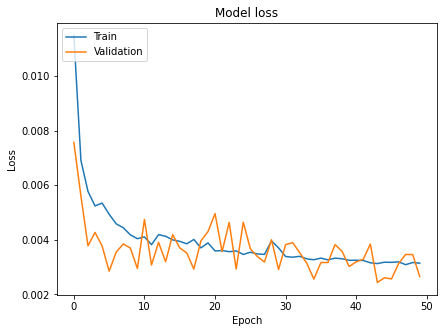

In [96]:
plt.rcParams["figure.figsize"] = (15,5)

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [97]:
def show_pwm_prediction3(pwms, preditions, text, start_id):
    
    
    idxs = range(start_id, start_id+len(preditions))    
    
    angs = list(zip(pwms.copy(), preditions))
    res = sorted(angs, key = lambda x: x[0])
    pwms, preditions  = zip(*res)
    
    data = zip()
    fig,ax = plt.subplots()
    ax.set_title(text)
    fig.figsize=(82, 6)

          
    ax.plot(idxs, preditions, 'o', color="blue")
    ax.plot(idxs, pwms, 'o', color="green")
    
    ax.set_xlabel('Sample Id')
    ax.set_ylabel('Angle by donkeycar', color="green")
        
    fig.set_figwidth(15)
    plt.show()
    
    #print(pwms[5000], pwms[10000], pwms[15000],pwms[20000], pwms[25000], pwms[30000])
    #print(preditions[5000], preditions[10000], preditions[15000],preditions[20000], preditions[25000], preditions[30000])
    
    

26/26 [==============================] - 0s 11ms/step


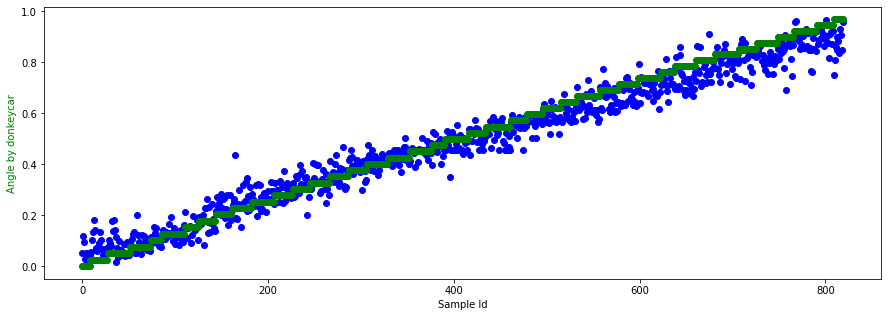

Sample count:  820
SSE 95230.76315008909


In [123]:
predictions=model.predict(testImagesX)
pwms2 = np.array(testPwmsX)
predictions2 = np.array(predictions)
show_pwm_prediction3(pwms2,predictions2,   '', 0)
show_statistics(testPwmsX, predictions, None)

In [130]:
 np.sum((abs(predictions.flatten() - testPwmsX)))

33.147989923165085

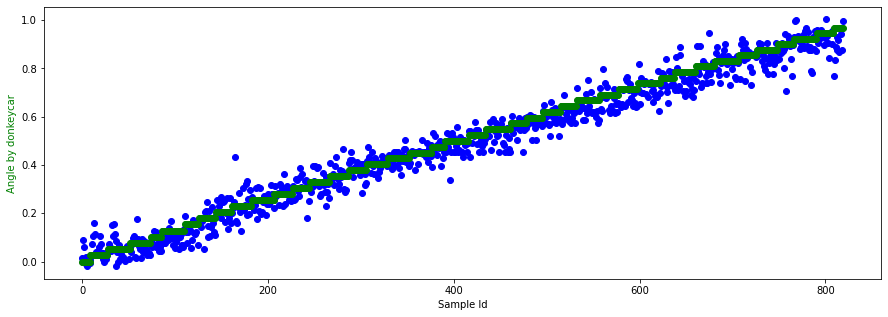

30.219810981680133

In [150]:
predictionsm=predictions+(predictions-0.5)*0.081
show_pwm_prediction3(testPwmsX,predictionsm,   '', 0)
np.sum((abs(predictionsm.flatten() - testPwmsX)))

In [149]:
for i in range(70,90):
    predictionsm=predictions+(predictions-0.5)*i*0.001
    print(i*0.001, np.sum((abs(predictionsm.flatten() - testPwmsX))))

0.07 30.26382082936697
0.07100000000000001 30.256144681992563
0.07200000000000001 30.24924663765816
0.073 30.243306914096515
0.074 30.23795317824997
0.075 30.233522411101237
0.076 30.229394677945585
0.077 30.22572761765978
0.078 30.222545893932622
0.079 30.22006854908748
0.08 30.219184178646934
0.081 30.219811100889423
0.082 30.220744353164413
0.083 30.222163350585074
0.084 30.22437984424885
0.085 30.227739372474844
0.08600000000000001 30.23141718022316
0.08700000000000001 30.236228788959405
0.088 30.24373537514652
0.089 30.252370236824824


In [120]:
testPwmsX

array([0.69106804, 0.52415408, 0.22906433, 0.17874677, 0.40260058,
       0.22906433, 0.47576903, 0.42706935, 0.61999244, 0.25409939,
       0.32871404, 0.49999931, 0.50000069, 0.90027605, 0.64376016,
       0.71460899, 0.10264648, 0.57222753, 0.73807512, 0.90027605,
       0.52415408, 0.64376016, 0.54822956, 0.15346356, 0.59614836,
       0.69106804, 0.52415408, 0.59614836, 0.80802852, 0.35342329,
       0.69106804, 0.17874677, 0.90027605, 0.22906433, 0.02578902,
       0.37805201, 0.12809691, 0.78478449, 0.05149288, 0.32871404,
       0.76146682, 0.92315775, 0.8311993 , 0.87732267, 0.20394691,
       0.52415408, 0.30392388, 0.12809691, 0.27905246, 0.8311993 ,
       0.42706935, 0.05149288, 0.90027605, 0.57222753, 0.25409939,
       0.50000069, 0.54822956, 0.20394691, 0.87732267, 0.12809691,
       0.20394691, 0.30392388, 0.57222753, 0.17874677, 0.80802852,
       0.50000069, 0.25409939, 0.78478449, 0.25409939, 0.10264648,
       0.8311993 , 0.73807512, 0.78478449, 0.35342329, 0.35342

In [99]:
residuals = abs(predictions.flatten() - testPwmsX)

In [101]:
residuals.min(),residuals.max(),residuals.mean(), np.median(residuals), np.std(residuals)


(6.978952987013454e-06,
 0.21956944619345564,
 0.040424377955079374,
 0.03224574433629576,
 0.03284316287480898)

In [102]:
a = list(zip(testPwmsX, predictions, residuals))


(array([79., 71., 64., 67., 65., 72., 47., 54., 43., 42., 29., 22., 26.,
        28., 20., 21., 18.,  7.,  7.,  4.,  4.,  9.,  8.,  3.,  0.,  1.,
         0.,  2.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         1.]),
 array([6.97895299e-06, 5.49604063e-03, 1.09851023e-02, 1.64741640e-02,
        2.19632257e-02, 2.74522874e-02, 3.29413490e-02, 3.84304107e-02,
        4.39194724e-02, 4.94085341e-02, 5.48975958e-02, 6.03866574e-02,
        6.58757191e-02, 7.13647808e-02, 7.68538425e-02, 8.23429042e-02,
        8.78319658e-02, 9.33210275e-02, 9.88100892e-02, 1.04299151e-01,
        1.09788213e-01, 1.15277274e-01, 1.20766336e-01, 1.26255398e-01,
        1.31744459e-01, 1.37233521e-01, 1.42722583e-01, 1.48211644e-01,
        1.53700706e-01, 1.59189768e-01, 1.64678829e-01, 1.70167891e-01,
        1.75656953e-01, 1.81146014e-01, 1.86635076e-01, 1.92124138e-01,
        1.97613199e-01, 2.03102261e-01, 2.08591323e-01, 2.14080385e-01,
        2.19569446e-01]),
 <BarContainer objec

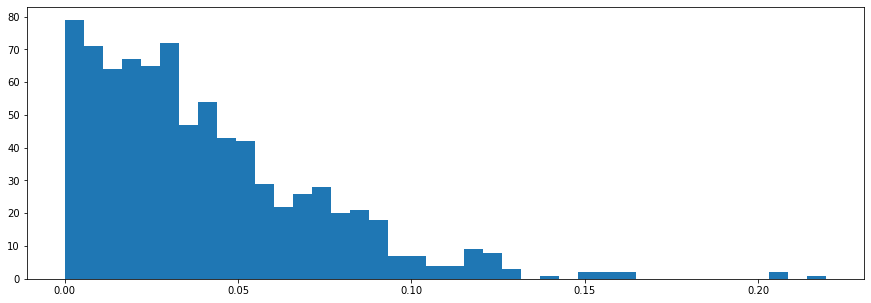

In [103]:
plt.hist(residuals, bins=40)

In [104]:
predictions=model.predict(augmentedTrainImages)

1995/1995 [==============================] - 21s 11ms/step


In [105]:
len(augmentedTrainImages)

63820

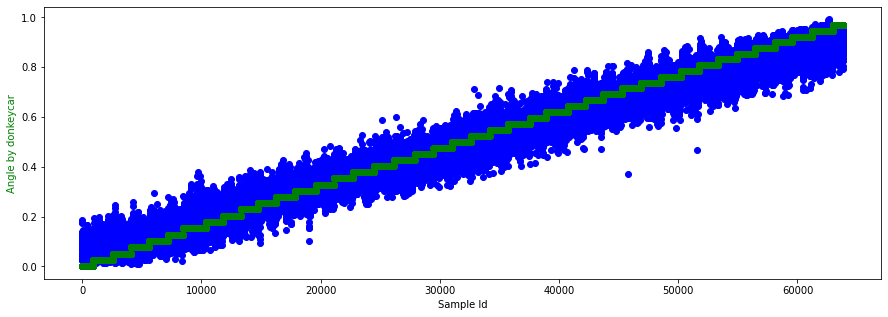

Sample count:  63820
SSE 7446019.369887636


In [114]:


pwms2 = np.array(augmentedPwms[0:])
predictions2 = np.array(predictions[0:])
show_pwm_prediction3(pwms2,predictions2,   '', 0)
show_statistics(testPwmsX, predictions, None)


In [116]:
 np.sum((abs(predictions - testPwmsX)))

206749.86941756326

In [108]:
d

1.0333797316075646

-1 delta:  0.34369789469036405 orig aug:  0.7146089862564499 pred:  0.3709111


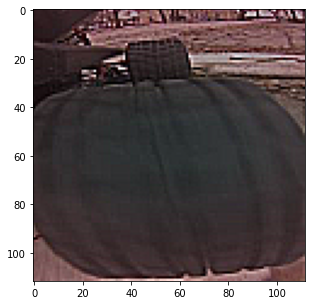

-2 delta:  0.31674971929165463 orig aug:  0.7847844933566723 pred:  0.46803477


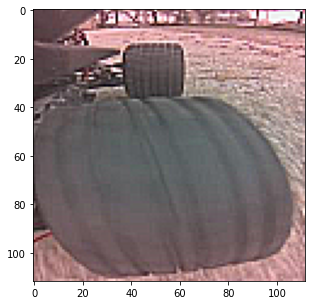

-3 delta:  0.22469030269443316 orig aug:  0.15346355787456709 pred:  0.37815386


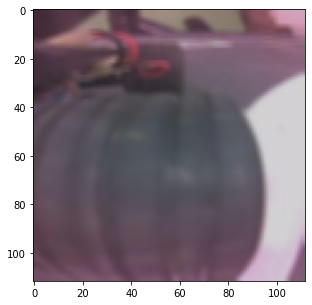

-4 delta:  0.2159272276956864 orig aug:  0.900276049335701 pred:  0.6843488


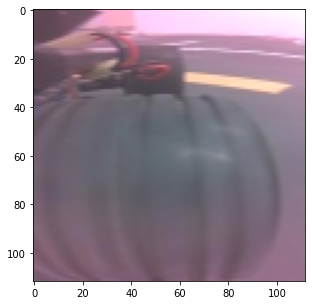

-5 delta:  0.21574395578133987 orig aug:  0.9231577483915083 pred:  0.7074138


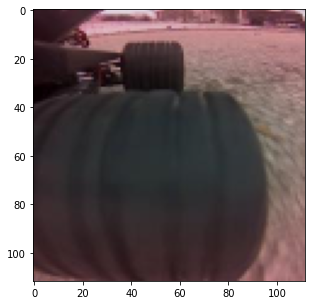

-6 delta:  0.2131991354726548 orig aug:  0.9231577483915085 pred:  0.7099586


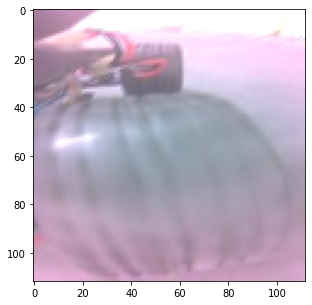

-7 delta:  0.2128099047739337 orig aug:  0.9002760493357013 pred:  0.68746614


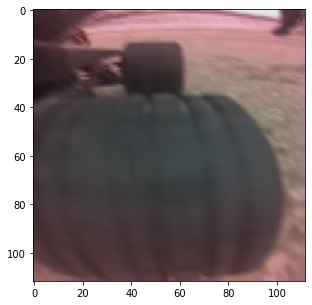

-8 delta:  0.20900325425922198 orig aug:  0.15346355787456709 pred:  0.3624668


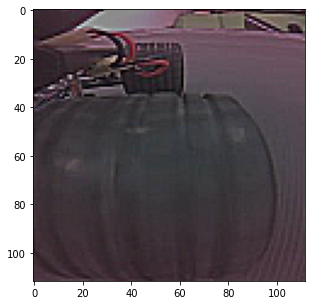

-9 delta:  0.20797510393916888 orig aug:  0.15346355787456709 pred:  0.36143866


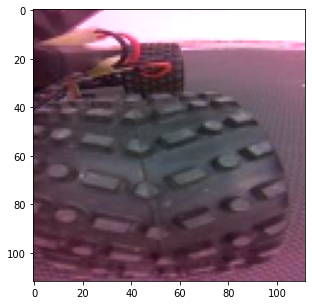

In [109]:
residuals2 = abs(predictions2.flatten() - augmentedPwms)

b = list(zip(residuals2, augmentedPwms, augmentedTrainImages, predictions2.flatten()))
res = sorted(b, key = lambda x: x[0])
residuals3, augmentedPwms3, augmentedTrainImages3, predictions3  = zip(*res)

for idx in range(1,10):

    print(-idx, 'delta: ',residuals3[-idx],'orig aug: ', augmentedPwms3[-idx], 'pred: ',predictions3[-idx])
    plt.imshow(augmentedTrainImages3[idx])
    plt.show()
    
    

In [41]:

residuals3[-1]

0.7374855160713198

In [185]:
def show_pwm_prediction(pwms, preditions, throttle, text,   start_id):
    
    
    idxs = range(start_id, start_id+len(preditions))
    
    fig,ax = plt.subplots()
    ax.set_title(text)
    fig.figsize=(82, 6)

    ax.plot(idxs, pwms, color="green")
        
    ax.plot(idxs, throttle, color="red")
    
    ax.set_xlabel('Sample Id')
    ax.set_ylabel('Angle and Throttle by donkeycar', color="green")
    
    ax2 = ax.twinx()
    ax2.plot(idxs, preditions)
    ax2.set_ylabel('Angle by camera', color="blue")
    
    fig.set_figwidth(15)
    plt.show()

def show_pwm_prediction2(pwms, preditions, text,   start_id):
    
    
    idxs = range(start_id, start_id+len(preditions))
    
    fig,ax = plt.subplots()
    ax.set_title(text)
    fig.figsize=(82, 6)

    ax.plot(idxs, pwms, color="green")
        
    ax.plot(idxs, preditions, 'o', color="blue")
    
    ax.set_xlabel('Sample Id')
    ax.set_ylabel('Angle by donkeycar', color="green")
        
    fig.set_figwidth(15)
    plt.show()
    
def show_statistics(pwms, predictions, frames=None):

    #print('Sample count: ', len(predictions))
    #print('Cov', np.corrcoef([pwms,predictions]))    

    if frames == None:
        frames = len(predictions)
    predictions2 = predictions[:frames]
    mean = (max(predictions2) - min(predictions2))/2
    predictions3 = (predictions2 -  (min(predictions2) + mean) ) / mean
    #sse = np.sum(((predictions3 - pwms)**2))
    sse = np.sum(((predictions - pwms)**2))
    
    print('Sample count: ', len(predictions3))
    print('SSE', sse)

In [186]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
#tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

from keras import backend as K
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:

def unconv_sigmoid_d(pwms,d):
    return (pwms-d)*(2.0*d)

In [179]:
d

1.0333797316075646

In [161]:
testImagesX.shape

(820, 112, 112, 3)

In [173]:
np.array(list(imgs)).shape

(8199, 112, 112, 3)

In [164]:
imgs

0       [[[89, 64, 70], [90, 65, 71], [90, 65, 71], [9...
1       [[[93, 63, 71], [94, 64, 72], [95, 65, 73], [9...
2       [[[89, 64, 70], [92, 67, 73], [93, 68, 74], [9...
3       [[[86, 63, 69], [87, 64, 70], [87, 64, 70], [9...
4       [[[91, 61, 69], [92, 62, 70], [92, 62, 70], [9...
                              ...                        
8194    [[[99, 58, 76], [96, 58, 76], [96, 59, 76], [9...
8195    [[[79, 53, 64], [80, 54, 65], [82, 54, 66], [8...
8196    [[[84, 53, 68], [84, 53, 68], [84, 53, 68], [8...
8197    [[[81, 51, 63], [83, 53, 65], [83, 53, 65], [8...
8198    [[[80, 50, 62], [82, 52, 64], [83, 53, 65], [8...
Name: image, Length: 8199, dtype: object